# Import packages

In [1]:
#Data Manipulation
import pandas as pd
import numpy as np
import psycopg2

# Data Vizualization
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

#Statistics
from scipy.stats import ks_2samp,kstest,ttest_ind


#Machine Learning
from sklearn.metrics import roc_auc_score



# Functions

In [2]:
#load sql table
def load_sql_table(tablename,conn):
    #select all values from table
    selectQuery = f"Select * From {tablename}"
    cur = conn.cursor()
    cur.execute(selectQuery)
    rows = cur.fetchall()
    conn.commit()

    # get column names
    cur.execute(f"Select * FROM {tablename} LIMIT 0")
    colnames = [desc[0] for desc in cur.description]

    df = pd.DataFrame(rows,columns=colnames)
    
    return df

def annotate_percentages (ax,df):

    percentage = df.value_counts()*100/len(df)
    patches = ax.patches
    for i in range(len(patches)):
        x = patches[i].get_x() + patches[i].get_width()/2
        y = patches[i].get_height()+1000
        ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

   

    return x, y


# Read data from SQL

In [3]:
#read credential to connect to server
credentials = pd.read_json("../../credentials.json",typ = "series")
dicio = credentials.to_dict()

#connect to server
conn = psycopg2.connect(database = dicio['database'], 
                        user = dicio['user'], 
                        host= dicio['host'],
                        password = dicio['password'],
                        port = dicio['port'])

#create cursor
cur = conn.cursor()


#get all table names
cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tablenames = []
for table in cur.fetchall():
    tablenames.append(table)



# Load Data

In [4]:
test_raw = load_sql_table(tablenames[0][0],conn)
train_raw = load_sql_table(tablenames[1][0],conn)

# 1 - Data Cleaning

In [5]:
df1 = train_raw.copy()

In [6]:
df1.dtypes

id                      object
gender                  object
age                     object
driving_license         object
region_code             object
previously_insured      object
vehicle_age             object
vehicle_damage          object
annual_premium          object
policy_sales_channel    object
vintage                 object
response                object
dtype: object

In [7]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.1 Change Variables Types

In [8]:
df1["id"] = df1["id"].astype(int)
df1["age"] = df1["age"].astype(int)
df1["annual_premium"] = df1["annual_premium"].astype(float)
df1["vintage"] = df1["vintage"].astype(int)


# 2 - Descriptive Analysis

In [9]:
df2 = df1.copy()

In [10]:
df2.shape

(381109, 12)

In [11]:
test_raw.shape

(127037, 11)

In [12]:
numerical_variables = df2.select_dtypes(include=["int","float"])
categorical_variables = df2.select_dtypes(include=["object"])


## 2.1 Numerical Variables

In [13]:
describe = numerical_variables.describe().T
skew = numerical_variables.skew()
kurtosis = numerical_variables.kurtosis()

describe["skew"] = skew.round(2)
describe["kurtosis"] = kurtosis.round(2)
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,0.00,-1.20
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,0.67,-0.57
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,1.77,34.00
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,0.00,-1.20


annual_premium have high kurtosis and skew

## 2.2 Categorical Variables

In [14]:
describe = categorical_variables.describe().T
describe["%"] = describe["freq"] / describe["count"]

describe

,count,unique,top,freq,%
gender,381109,2,Male,206089,0.540761
driving_license,381109,2,1,380297,0.997869
region_code,381109,53,28.0,106415,0.279225
previously_insured,381109,2,0,206481,0.54179
vehicle_age,381109,3,1-2 Year,200316,0.525613
vehicle_damage,381109,2,Yes,192413,0.504877
policy_sales_channel,381109,155,152.0,134784,0.353663
response,381109,2,0,334399,0.877437


response, driving license and policy_sales_channel are unbalanced

In [15]:
df2["policy_sales_channel"].value_counts()/len(df2)

policy_sales_channel
152.0    0.353663
26.0     0.209127
124.0    0.194157
160.0    0.057146
156.0    0.027974
           ...   
149.0    0.000003
43.0     0.000003
144.0    0.000003
143.0    0.000003
41.0     0.000003
Name: count, Length: 155, dtype: float64

# 3 - Feature Engineering

In [16]:
df3 = df2.copy()

In [17]:
df3

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


# 4 - Criação de hipóteses 

1. Clientes do gênero masculino tem mais interesse em seguro de carro
2. Clientes com mais de 60 anos tem mais interesse em seguro de carro
3. Clientes com mais de 60 anos pagam mais anualmente em média
4. Clientes com carteira de motorista tem mais interesse em seguro de carro
5. Clientes da região 28 tem mais interesse em seguro de carro
6. Clientes que já tiverem seguro de carro tem mais interesse em seguro de carro
7. Clientes com veículos com menos de um ano tem mais interesse em seguro de carro
8. Clientes que pagam mais de 8000 por ano tem mais interesse em seguro de carro
9. Clientes que são ativados pelo canal de aquisição 26 tem mais interesse em seguro de carro
10. Clientes que tem mais de 150 dias associados à empresa tem mais interesse ems seguro de carro
11. Clientes que já danificaram seus veículos tem mais interesse em seguro de carro
12. Clientes do gênero masculino pagam mais anualmente


# 5 - Exploratory Data Analysis

In [18]:
df5 = df3.copy()

## 5.1 Analise Univariada

### 5.1.1 Variável Resposta

<Axes: ylabel='count'>

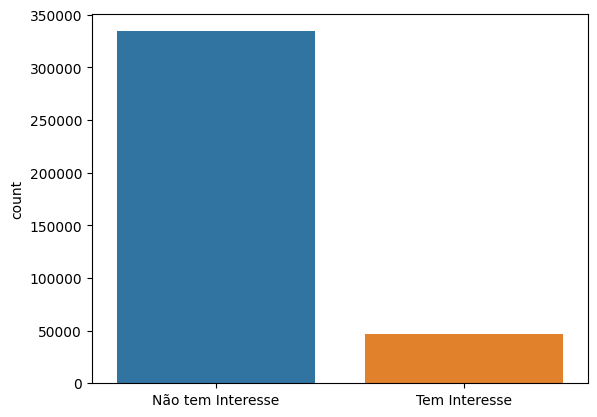

In [19]:
sns.barplot(x = ["Não tem Interesse","Tem Interesse"],y = df5["response"].value_counts())

## 5.1.2 Variáveis Numéricas

<Axes: xlabel='vintage', ylabel='Density'>

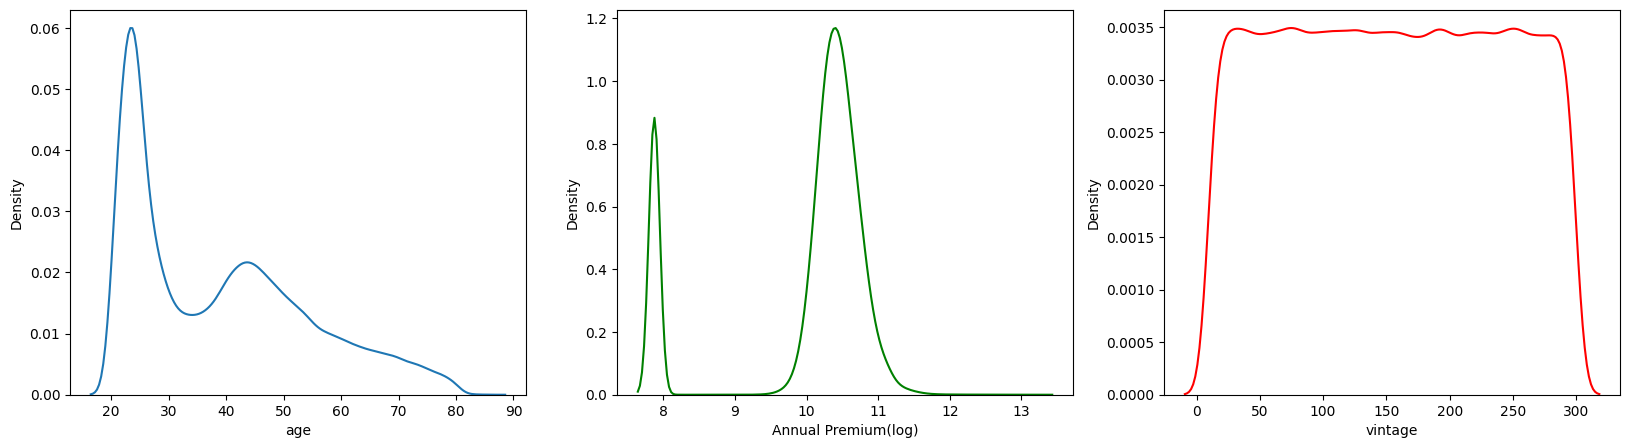

In [20]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.kdeplot(df5["age"])
plt.subplot(1,3,2)
plt.xlabel("Annual Premium(log)")
sns.kdeplot(np.log(df5["annual_premium"]),color='g')
plt.subplot(1,3,3)
sns.kdeplot(df5["vintage"],color='r')

## 5.1.3 Variáveis Categóricas

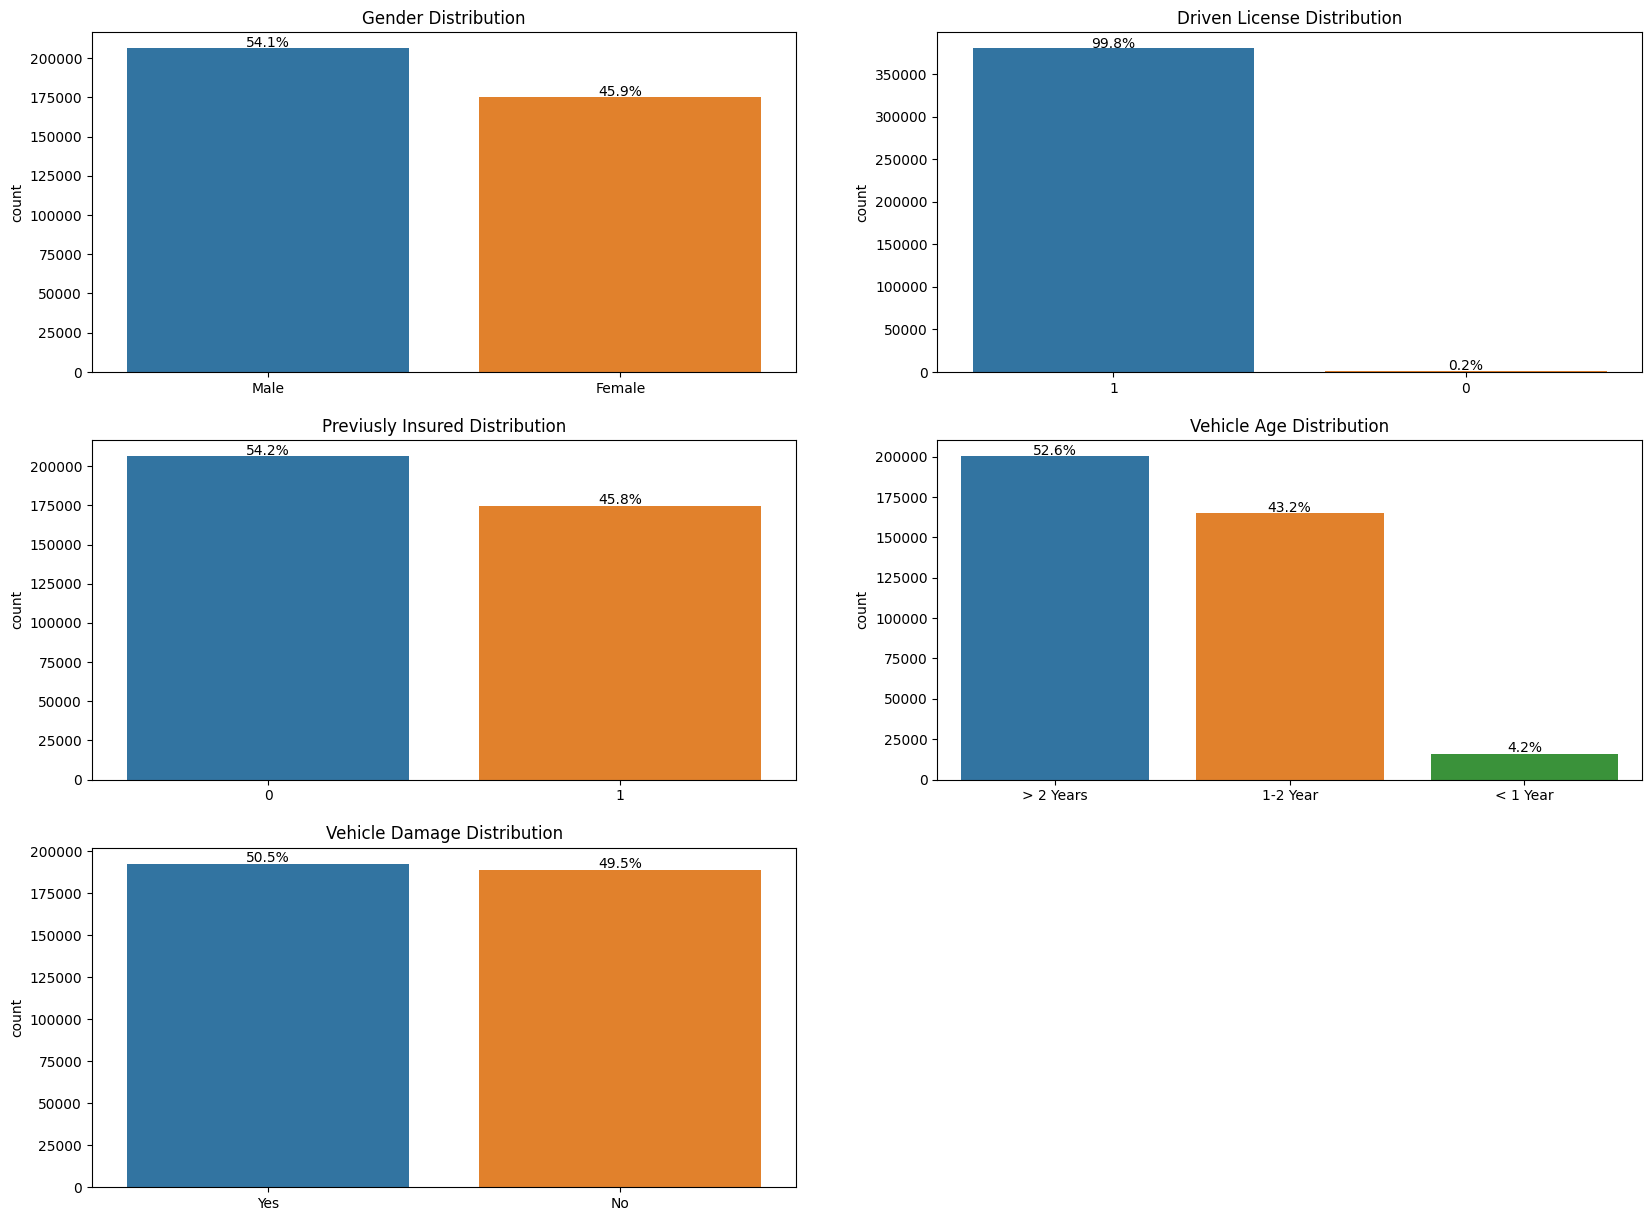

In [21]:
plt.figure(figsize=(20,15))


plt.subplot(3,2,1)
plt.title("Gender Distribution")
ax1 =sns.barplot(x=df5["gender"].unique() ,y= df5["gender"].value_counts())
annotate_percentages(ax1,df5["gender"])

plt.subplot(3,2,2)
plt.title("Driven License Distribution")
ax2 =sns.barplot(x=df5["driving_license"].unique() ,y= df5["driving_license"].value_counts())
annotate_percentages(ax2,df5["driving_license"])

plt.subplot(3,2,3)
plt.title("Previusly Insured Distribution")
ax3 =sns.barplot(x=df5["previously_insured"].unique() ,y= df5["previously_insured"].value_counts())
annotate_percentages(ax3,df5["previously_insured"])

plt.subplot(3,2,4)
plt.title("Vehicle Age Distribution")
ax4 =sns.barplot(x=df5["vehicle_age"].unique() ,y= df5["vehicle_age"].value_counts())
annotate_percentages(ax4,df5["vehicle_age"])

plt.subplot(3,2,5)
plt.title("Vehicle Damage Distribution")
ax5 =sns.barplot(x=df5["vehicle_damage"].unique() ,y= df5["vehicle_damage"].value_counts())
annotate_percentages(ax5,df5["vehicle_damage"])

plt.show()

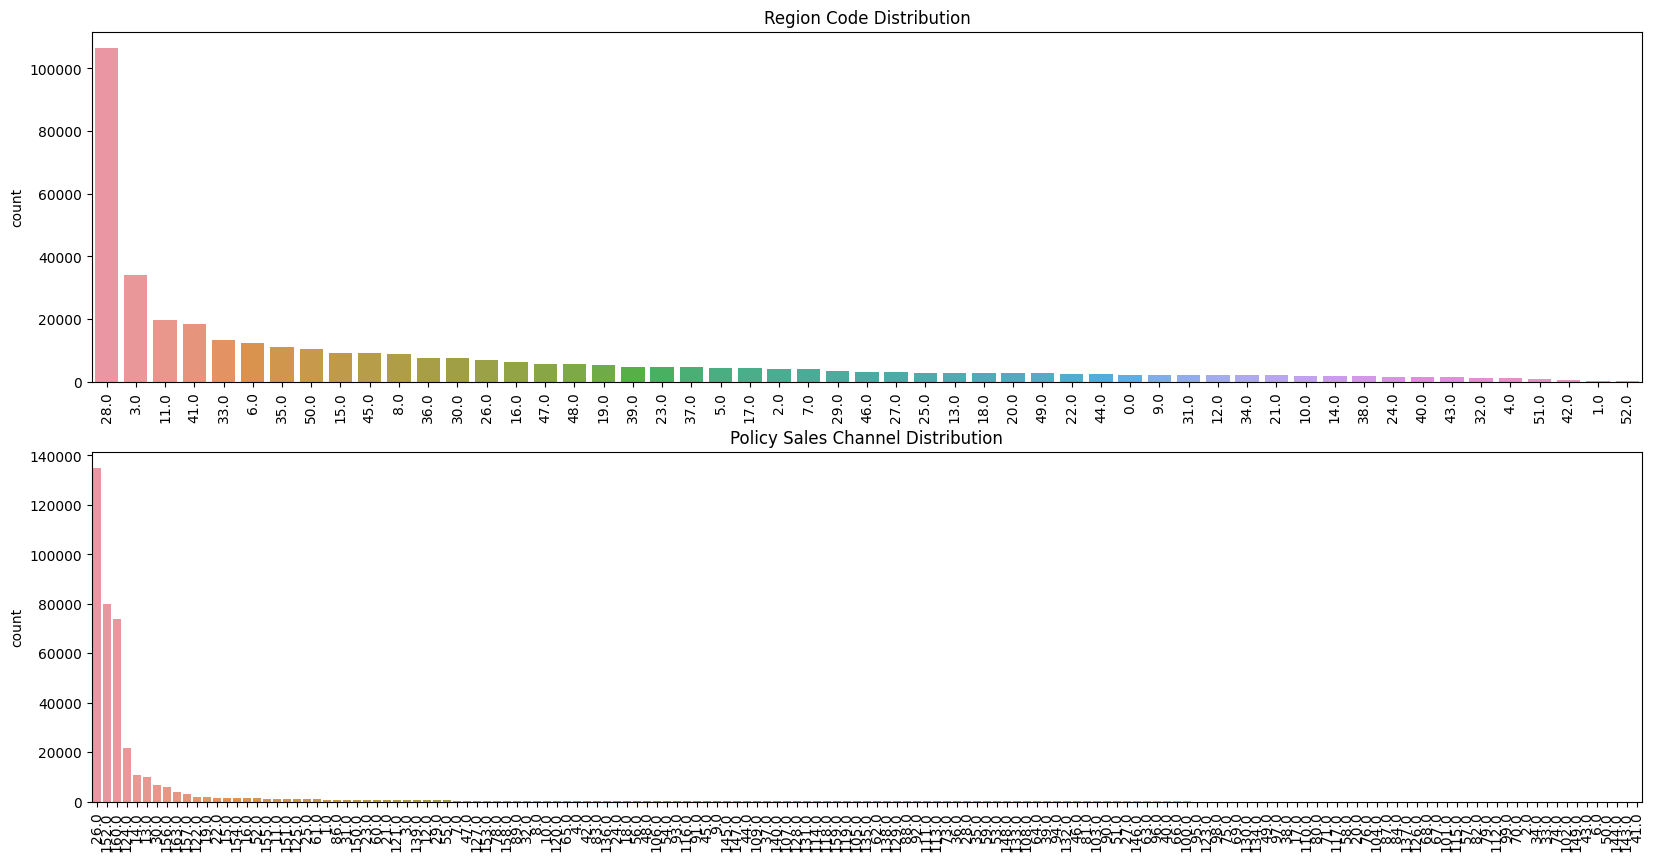

In [22]:
plt.figure(figsize= (20,10))

plt.subplot(2,1,1)
plt.title('Region Code Distribution')
plt.xticks(rotation = 90)
sns.barplot(x=df5["region_code"].unique() ,y= df5["region_code"].value_counts())

plt.subplot(2,1,2)
plt.title('Policy Sales Channel Distribution')
plt.xticks(rotation = 90)
sns.barplot(x=df5["policy_sales_channel"].unique() ,y= df5["policy_sales_channel"].value_counts());

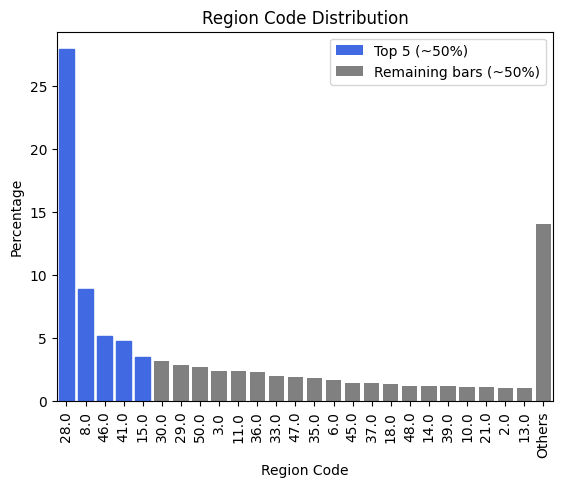

In [23]:
region_code_percentage = df5["region_code"].value_counts()*100/len(df5)
others = region_code_percentage[region_code_percentage < 1].sum()
top_region_code_percentage = region_code_percentage[region_code_percentage >= 1]
top_region_code_percentage["Others"] = others


plt.title("Region Code Distribution")
plt.xticks(rotation = 90)
ax = sns.barplot(x=top_region_code_percentage.index,y = top_region_code_percentage,color="grey")
patches = ax.patches
for bar in patches[:5]:
    bar.set_color("royalblue")

# Create a custom legend
legend_elements = [
    Patch(facecolor='royalblue', label='Top 5 (~50%)'),
    Patch(facecolor='grey', label='Remaining bars (~50%)')
]

# Add the legend to the plot
plt.legend(handles=legend_elements)

plt.xlabel("Region Code")
plt.ylabel("Percentage");

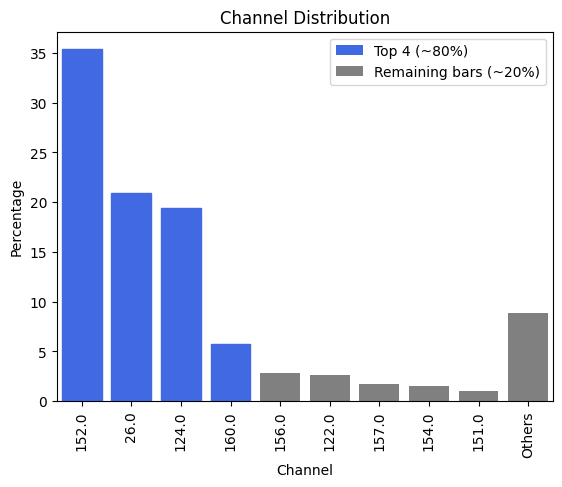

In [24]:
channel_percentage = df5["policy_sales_channel"].value_counts()*100/len(df5)
others = channel_percentage[channel_percentage < 1].sum()
top_channel_percentage = channel_percentage[channel_percentage >= 1]
top_channel_percentage["Others"] = others


plt.title("Channel Distribution")
plt.xticks(rotation = 90)
ax = sns.barplot(x=top_channel_percentage.index,y = top_channel_percentage,color="grey")
patches = ax.patches
for bar in patches[:4]:
    bar.set_color("royalblue")

# Create a custom legend
legend_elements = [
    Patch(facecolor='royalblue', label='Top 4 (~80%)'),
    Patch(facecolor='grey', label='Remaining bars (~20%)')
]

# Add the legend to the plot
plt.legend(handles=legend_elements)

plt.xlabel("Channel")
plt.ylabel("Percentage");

## 5.2 Analise Bivariada

1. Clientes do gênero masculino tem mais interesse em seguro de carro <br />
__True__

In [25]:
df5["response"] = df5["response"].astype(int)
df5[["response","gender"]].groupby("gender").mean().reset_index().rename(columns={"response" : "Porcentagem de interesse"})


,gender,Porcentagem de interesse
0,Female,0.103902
1,Male,0.138411


2. Clientes com mais de 60 anos tem mais interesse em seguro de carro <br />
__FALSE__ Clientes com menos de 60 tem em média mais interesse que clientes com mais de 60 anos

In [26]:
older = round(df5[df5["age"] > 60]["response"].mean() * 100,2)
younger = round(df5[df5["age"] < 60]["response"].mean() * 100,2)

print(f"{older}% dos clientes com mais de 60 anos tem interesse em seguro de carro")
print(f"{younger}% dos clientes com menos de 60 anos tem interesse em seguro de carro")


9.69% dos clientes com mais de 60 anos tem interesse em seguro de carro
12.58% dos clientes com menos de 60 anos tem interesse em seguro de carro


3. Clientes com mais de 60 anos pagam mais anualmente em média <br/>
__TRUE__

In [27]:
older = df5[df5["age"] > 60]["annual_premium"]
younger = df5[df5["age"] < 60]["annual_premium"]

print(f"Média do valor pago por clientes com mais de 60 anos:{older.mean()}")
print(f"Média do valor pago por clientes com menos de 60 anos:{younger.mean()}")


Média do valor pago por clientes com mais de 60 anos:33603.04329424825
Média do valor pago por clientes com menos de 60 anos:30156.70588569583


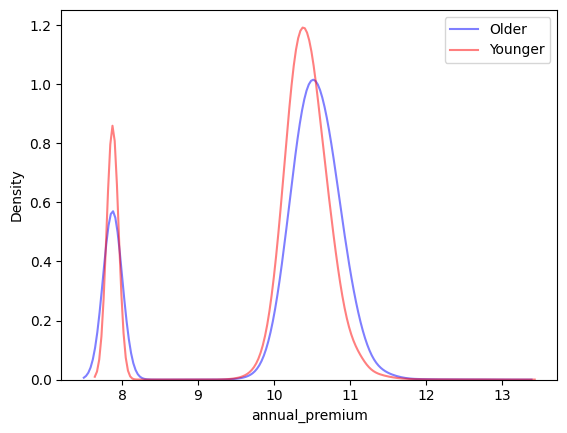

In [28]:
plt.subplot(1,1,1)
sns.kdeplot(np.log(older),color = "b",alpha = 0.5)
sns.kdeplot(np.log(younger),color="r",alpha = 0.5)
plt.legend(["Older","Younger"])
plt.show()

4. Clientes com carteira de motorista tem mais interesse em seguro de carro <br/>
__TRUE__

In [42]:
with_license = round(df5[df5["driving_license"] == "1"]["response"].mean()*100,2)
without_license = round(df5[df5["driving_license"] == "0"]["response"].mean()*100,2)


print(f"{with_license}% dos clientes com carteira de motorista tem interesse em seguro de carro")
print(f"{without_license}% dos clientes sem carteira de motorista tem interesse em seguro de carro")


12.27% dos clientes com carteira de motorista tem interesse em seguro de carro
5.05% dos clientes sem carteira de motorista tem interesse em seguro de carro


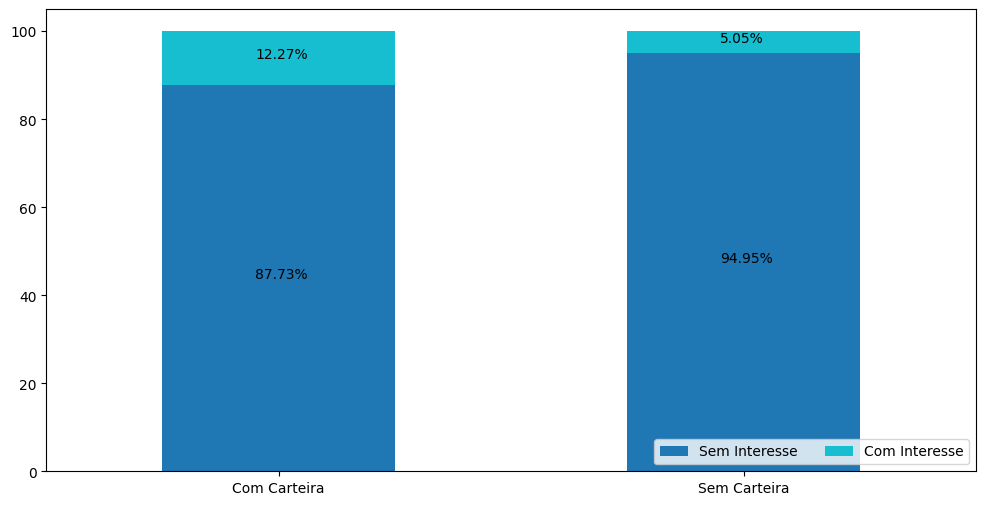

In [84]:
with_license = df5[df5["driving_license"] == "1"]["response"]
percentages_with = round(with_license.value_counts()*100/len(with_license),2)

without_license = df5[df5["driving_license"] == "0"]["response"]
percentages_without = round(without_license.value_counts()*100/len(without_license),2)

cross_tab = pd.DataFrame([percentages_with,percentages_without],index=[0,1])


cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))



plt.xticks([0,1],["Com Carteira","Sem Carteira"],rotation= 0)
plt.legend(["Sem Interesse","Com Interesse"],loc = "lower right",ncol = 2)

for index, row in cross_tab.iterrows():
        
    plt.text(x=index - 0.05,
             y=row[0]/2,
             s = f"{row[0]}%")
    
    plt.text(x=index - 0.05,
             y=row[0] + row[1]/2,
             s = f"{row[1]}%")




5. Clientes da região 28 tem mais interesse em seguro de carro <br/>

In [85]:
df5[["region_code","response"]].groupby("region_code").mean().reset_index()


,region_code,response
0,0.0,0.086096
1,1.0,0.108135
2,10.0,0.060128
3,11.0,0.112760
4,12.0,0.097561
5,13.0,0.090188
6,14.0,0.090209
7,15.0,0.071987
8,16.0,0.066766
9,17.0,0.070310


8. Clientes que pagam mais de 8000 por ano tem mais interesse em seguro de carro<br/>
__FALSE__

In [29]:
greater = round(df5[df5["annual_premium"] > 8000]["response"].mean()*100,2)
less = round(df5[df5["annual_premium"] < 8000]["response"].mean()*100,2) 

print(f"{greater}% dos clientes que pagam mais de 8000 por ano tem interesse em seguro de carro")
print(f"{less}% dos clientes que pagam menos de 8000 por ano tem interesse em seguro de carro")

12.08% dos clientes que pagam mais de 8000 por ano tem interesse em seguro de carro
13.11% dos clientes que pagam menos de 8000 por ano tem interesse em seguro de carro


12. Clientes do gênero masculino pagam mais anualmente (As ditribuições de pagamento anual para homens e mulhers são iguais)


In [30]:
df5[["annual_premium","gender"]].groupby("gender").mean().reset_index()

,gender,annual_premium
0,Female,30495.787990
1,Male,30622.649122


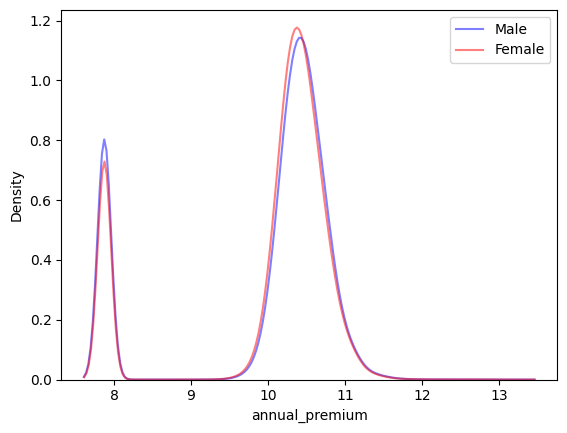

In [31]:
plt.subplot(1,1,1)
sns.kdeplot(np.log(df5[df5["gender"] == "Male"]["annual_premium"]),color = "b",alpha = 0.5)
sns.kdeplot(np.log(df5[df5["gender"] == "Female"]["annual_premium"]),color="r",alpha = 0.5)
plt.legend(["Male","Female"])
plt.show()


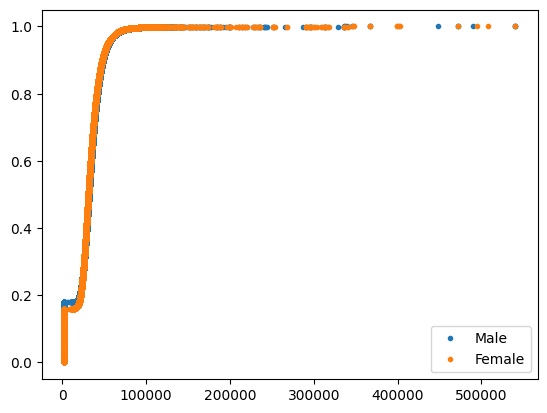

In [32]:
#Hipótese Nula: As duas variáveis são igualmente distribuídas
# Teste de Kolmogorov-Smirnov Unidimensional:

# O teste KS compara o formato das distribuições, não parametros como disperção e tendencia central (Não paramétrico)
# Para comparar duas variáveis unidimensionais, você calcula a ECDF para cada variável.
# Em seguida, aplica o teste KS para determinar se as duas ECDFs são estatisticamente diferentes.
# O teste KS retorna um valor p, que indica a probabilidade de as duas variáveis serem provenientes da mesma distribuição. Se o valor p for maior que um nível de significância pré-definido (geralmente 0.05), você não rejeita a hipótese nula de igualdade das distribuições.

x_male,y_male = ecdf(df5[df5["gender"] == "Male"]["annual_premium"])
x_female,y_female = ecdf(df5[df5["gender"] == "Female"]["annual_premium"])

plt.plot(x_male,y_male,linestyle="none",marker = ".")
plt.plot(x_female,y_female,linestyle="none",marker = ".")
plt.legend(["Male","Female"])



In [33]:
statistic, p_value = ks_2samp(x_male, x_female,alternative = "two-sided") #teste nao paramétrico

print("Estatística de teste:", statistic)
print("Valor p:", p_value)

# As distribuições do valor pago por homens e mulheres são, estatisticamente, diferentes

Estatística de teste: 0.027855838409961753
Valor p: 3.118747150461598e-64


In [34]:
#teste t Student para comparar as médias das duas distribuições
statistic, p_value = ttest_ind(x_male,x_female) 

print("Estatística de teste:", statistic)
print("Valor p:", p_value)

# As distribuições do valor pago por homens e mulheres são, estatisticamente, diferentes

Estatística de teste: 2.267342380723392
Valor p: 0.023369875916187475
